# Topic Modelling of World War 1 Letters 

Topic modelling is a form of unsupervised machine learning which is especially good at finding meaning in large, unstructured, text documents. The method has gained a lot of interest from a wide array of fields due to its potential for finding semantic information and visualising this in an appealing and understandable way. As a method, it certainly has a unique ability to detect patterns and extract insights from datasets which are usually out of reach for other machine learning approaches. This may be due to their messy structure and/or scale. However, anyone working with topic modelling should take care to document their pre-processing of the data before feeding it to the model. This is because the steps taken to slice and dice the words will play a big role in the topics which come out.

In [1]:
#operating systems 
import os
import sys
sys.path.append(os.path.join(".."))
from pprint import pprint

# data handling 
import pandas as pd
import numpy as np 
import re 

#stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
custom_stopwords = ["Dear", "dear", "Yours sincerely", "Kind regards", "Kindest regards", "sincerely", "Regards"]
stop_words = stopwords.words('english')
stop_words.extend(custom_stopwords)

# nlp functionality 
import spacy
nlp = spacy.load("en_core_web_sm", disable=["ner"])


# visualisations 
import pyLDAvis.gensim
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 20,10

#LDA tools 
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import utils.lda_utils as lda_utils

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /home/cds-
[nltk_data]     au604588/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/cds-au604588/WorldWarI/language_analytics03/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [25]:
#Load in the data 
data_path = "../data/100_Letters.csv"

In [26]:
#Create a pandas dataframe with it 
data = pd.read_csv(data_path)

In [27]:
#Create a subset of only the text column 
lines = data['text']

In [28]:
type(lines)

pandas.core.series.Series

In [29]:
#Convert object to a list 
text_list =[]

for line in lines: 
    text_list.append(line)

In [30]:
#The next step is to make it into a string for processing
#The join() function here needs to be reinforced by the map() function 
string = (', '.join(map(str, text_list)))

In [31]:
type(string)

str

__Cleaning up the text data__

As the data has been curated from various sources, the data is messy and suffering from the conversion our of json and into csv style. Therefore, we'll do some manual cleaning of it to take away all the unwanted punctuation noise: 

In [32]:
#We'll start with a regex expression first to catch most of the characters
cleaned_text = re.sub(r'[^\w\s\n\\n]', '', string)

In [33]:
#Check how it's looking 
cleaned_text

'Dear wife my two kids and all my family I will tell you that I have reached Magnac and we are leaving for Paris next Thursday to go to the border of Germany I will tell you that since Sunday I have not eaten two cents of food when at the moment I have 50000000 ideas in my head but anyway I am not sick I will tell you that we arrested a German spy and I guarantee you that he is not at the end of his sentences There are three spies who were executed but not in Magnac very close to Paris this is the last letter I am writing to you because afterwards I think that I will not be able anymore or if I rewrite it will be when I get to Paris At the moment it seems that things are going badly but I will fight to the end for the honor of all to save you if I can and all my comrades I promised you almost solemnly to tell you the truth I will do it but on the other hand you gave me the assurance that you would have strong nerves and a firm heart I have been since this morning in conquered trenches 

In [34]:
#Some of the more unusual patterns have slipped through so we'll clean these manually
cleaned_text = cleaned_text.replace("\\n\\n", " ")
cleaned_text = cleaned_text.replace("\n", " ")
cleaned_text = cleaned_text.replace("\'", " ")
cleaned_text = cleaned_text.replace("\'t", " ")
cleaned_text = cleaned_text.replace("\\n", " ")


In [35]:
cleaned_text #It's looking much better! 

'Dear wife my two kids and all my family I will tell you that I have reached Magnac and we are leaving for Paris next Thursday to go to the border of Germany I will tell you that since Sunday I have not eaten two cents of food when at the moment I have 50000000 ideas in my head but anyway I am not sick I will tell you that we arrested a German spy and I guarantee you that he is not at the end of his sentences There are three spies who were executed but not in Magnac very close to Paris this is the last letter I am writing to you because afterwards I think that I will not be able anymore or if I rewrite it will be when I get to Paris At the moment it seems that things are going badly but I will fight to the end for the honor of all to save you if I can and all my comrades I promised you almost solemnly to tell you the truth I will do it but on the other hand you gave me the assurance that you would have strong nerves and a firm heart I have been since this morning in conquered trenches 

In [36]:
#There's lots of numbers in here, which aren't going to be useful to our analysis so we'll remove these also
#Remove digits from the text
pattern = r'[0-9]'
cleaned_text = re.sub(pattern, '', cleaned_text)

A quick "control" "f" tells us there are a few times that have slipped through but not a lot else, so we're looking pretty good! 

## Preparing the data for topic modelling

In [37]:
#cleaned_text is not a good variable name so we'll rename it 
text = cleaned_text

In [38]:
#Calling in spacy to run through our data 
doc = nlp(text)
sentences = [sent.string.strip() for sent in doc.sents]

In [39]:
#Our sentences are small in size so we'll lump them together into chunks of 5 sentences at a time 
chunks = []
for i in range(0, len(sentences), 5):
    chunks.append(' '.join(sentences[i:i+5]))

In [40]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(chunks, min_count=3, threshold=15) # lowering threshold as it's a small dataset 
trigram = gensim.models.Phrases(bigram[chunks], threshold=15)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [41]:
#We want to take nouns, adjectives and verbs first 
data_processed = lda_utils.process_words(chunks,nlp, bigram_mod, trigram_mod, allowed_postags=["ADJ", "NOUN"])

Next, we need a gensim dictionary and corpus: 

Dictionary = converts each word into an integer value

Corpus = creates a 'bag of words' model

In [42]:
# Create Dictionary (to convert each word to an integer value)
id2word = corpora.Dictionary(data_processed)

# Create Corpus: Term Document Frequency (to create bag of words model) 
corpus = [id2word.doc2bow(text) for text in data_processed]

In [46]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,    #creating the bag of words 
                                       id2word=id2word,  #mapping our word IDs to words 
                                       num_topics=5,    #Defining that we want 10 topics 
                                       random_state=42,  #Setting a random seed 
                                       chunksize=5,  
                                       passes=10,        #Number of passes through corpus during training
                                       iterations=100,   #We want the model to iterate over the data 100 times 
                                       per_word_topics=True,  #We want to assign each word topic 
                                       minimum_probability=0.00) #Topics with threshold lower than this will be filtered

__Evaluating the LDA model__

__Perplexity__ is a statistical measure of how well a probability model predicts a sample. It is measured as the normalized log-likelihood of a test set. The measure is somewhat meaningless on it's own, but can be thought of as measuring how probable some new unseen data is given the model that was learned earlier. The benefit of this statistic comes in comparing perplexity across different models. The model with the lowest perplexity is the best!

__Coherence__  Topic coherence combines a number of measures into a framework to evaluate the coherence between topics inferred by a model. It is used alongside the perplexity to make up for some of the shortcomings of the the ambiguous perplexity measure. Coherence is based on the idea of semantics, where it measures a single topic by measuring the degree of semantic similarity between high scoring words in the topic.


In [47]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=data_processed, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

#With nouns adj and verbs (perplexity = -7.67m coherence = 0.2 )
#with just nouns (Perplexity = -7.4, coherence = .49)
#with adjectives (Perplexity = -6.61, coherence = .68)
#with verbs (Perplexity = -6.45, coherence = .49)
#nourns and adjectives togeter P= -7.49, coherence == .397
#adj and verbs P= -6.86 C = .35 (Optimal topics = 8)
#nouns and verbs: P = -7.2 C = .30 (optimal 8)



Perplexity:  -7.378676163427596

Coherence Score:  0.3372497098232422


__Final choice__: Nouns and Adjectives with 7 topics (Perplexity = -7.59, Coherence = 0.44)

In [48]:
#We also want to see which keywords are being used to define the topics 
pprint(lda_model.print_topics())

[(0,
  '0.027*"course" + 0.016*"place" + 0.014*"day" + 0.013*"love" + 0.011*"bad" + '
  '0.011*"last" + 0.010*"good" + 0.010*"time" + 0.010*"war" + 0.009*"hour"'),
 (1,
  '0.028*"day" + 0.024*"time" + 0.019*"week" + 0.019*"last" + 0.018*"line" + '
  '0.017*"letter" + 0.014*"thing" + 0.012*"good" + 0.012*"many" + '
  '0.012*"trench"'),
 (2,
  '0.019*"night" + 0.017*"trench" + 0.016*"gun" + 0.013*"line" + 0.012*"lot" + '
  '0.012*"man" + 0.011*"day" + 0.010*"shell" + 0.010*"time" + 0.010*"german"'),
 (3,
  '0.028*"time" + 0.023*"good" + 0.016*"old" + 0.012*"boy" + 0.012*"present" + '
  '0.009*"office" + 0.008*"letter" + 0.008*"fine" + 0.008*"much" + '
  '0.008*"long"'),
 (4,
  '0.015*"mud" + 0.013*"troop" + 0.011*"day" + 0.009*"little" + 0.009*"air" + '
  '0.009*"top" + 0.008*"letter" + 0.008*"face" + 0.008*"suppose" + '
  '0.007*"people"')]


__Hyperparameter Tuning__

We can explore the optimal number of topics for our topic by calling the compute_coherence_values function from our utils folder. This will check to see what the optimal number of chunks will be in steps of 2, starting at 1 and with a maximum of 16 topics.  

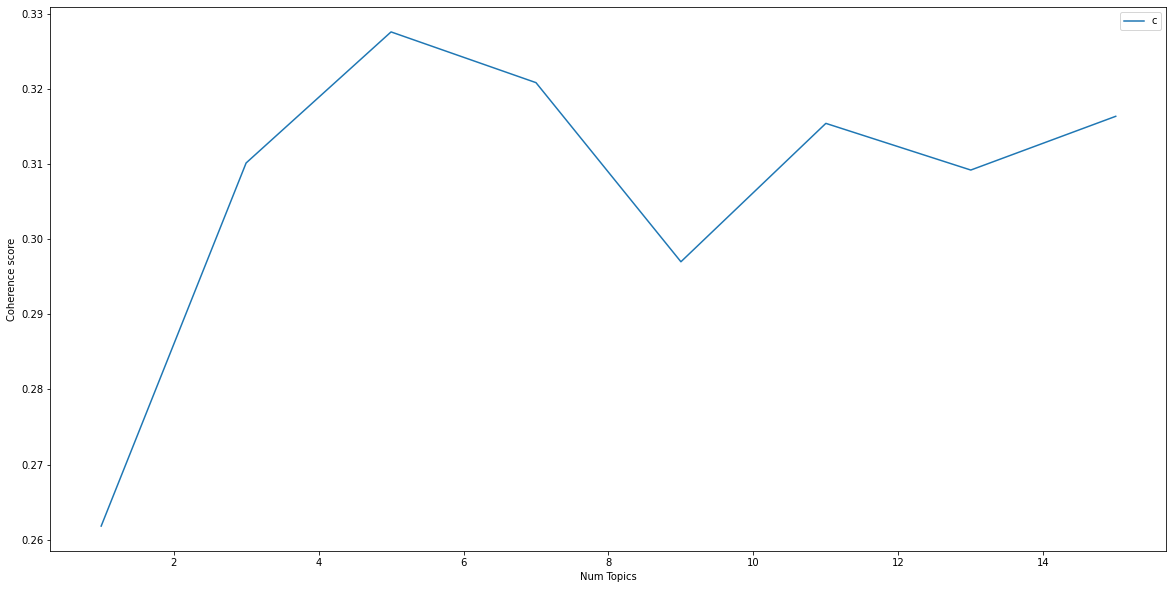

Num Topics = 1  has Coherence Value of 0.2618
Num Topics = 3  has Coherence Value of 0.3101
Num Topics = 5  has Coherence Value of 0.3276
Num Topics = 7  has Coherence Value of 0.3208
Num Topics = 9  has Coherence Value of 0.297
Num Topics = 11  has Coherence Value of 0.3154
Num Topics = 13  has Coherence Value of 0.3092
Num Topics = 15  has Coherence Value of 0.3163


In [49]:
# Can take a long time to run.
model_list, coherence_values = lda_utils.compute_coherence_values(texts=data_processed,
                                                                  corpus=corpus, 
                                                                  dictionary=id2word,  
                                                                  start=1, 
                                                                  limit=16,  
                                                                  step=2)

Our optimal number of topics appears to be 5! 

## Vizualising our topics

Below we can view which topic is the most dominent in a sample of random sentences. We're told the keywords which make up that topic and a sample of the text left from our parsed sentences 

In [50]:
#We'll start with a dataframe of the most popular topics among some of the sentences
df_topic_keywords = lda_utils.format_topics_sentences(ldamodel=lda_model, 
                                                      corpus=corpus, 
                                                      texts=data_processed)

# Format (we'll view a sample of 10)
df_dominant_topic = df_topic_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.sample(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
375,375,3.0,0.6900,"time, good, old, boy, present, office, letter,...","[spot, consisted, piece, gauze, tape, solution..."
311,311,2.0,0.7152,"night, trench, gun, line, lot, man, day, shell...","[whisper, stafford, stafford, stop, think, pos..."
291,291,2.0,0.6445,"night, trench, gun, line, lot, man, day, shell...","[numerous, certain, year, terrific, ship, ship..."
282,282,3.0,0.4972,"time, good, old, boy, present, office, letter,...","[day, care, darling, put, trust, sure, wonder,..."
260,260,2.0,0.7619,"night, trench, gun, line, lot, man, day, shell...","[known, revert, sapper, sufficient, man, ncos,..."
44,44,2.0,0.9834,"night, trench, gun, line, lot, man, day, shell...","[superior, soldier, evening, state, soldier, m..."
402,402,3.0,0.5325,"time, good, old, boy, present, office, letter,...","[trust, little, sweetheart, kiss, thankful, lu..."
176,176,3.0,0.6925,"time, good, old, boy, present, office, letter,...","[sergeant, able, detail, kind, friend, audit, ..."
120,120,4.0,0.3998,"mud, troop, day, little, air, top, letter, fac...","[work, naval, division, brother, commission, w..."
212,212,4.0,0.5680,"mud, troop, day, little, air, top, letter, fac...","[course, amount, mining, particular, lump, ear..."


__Then we'll look at sentences which are most representative of each topic (in the representative text column)__

In [51]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

#sort the topics into their dominant topic 
sent_topics_sorteddf = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                      grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                      axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9811,"course, place, day, love, bad, last, good, time, war, hour","[hand, assurance, strong, nerve, heart, morning, day, gut, form, labyrinth, hour, last, night, t..."
1,1.0,0.9824,"day, time, week, last, line, letter, thing, good, many, trench","[fort, day, cruiser, monitor, bay, land, battery, trench, long, time, boom, shell, head, trench,..."
2,2.0,0.9834,"night, trench, gun, line, lot, man, day, shell, time, german","[superior, soldier, evening, state, soldier, man, high, position, warm, developing, slight, sign..."
3,3.0,0.9784,"time, good, old, boy, present, office, letter, fine, much, long","[next, day, night, heat, water, dig, light, job, ostrich, hole, large, enough, head, lackmany, p..."
4,4.0,0.9759,"mud, troop, day, little, air, top, letter, face, suppose, people","[lot, gear, gas, meal, night, cold, length, gut, difficulty, large, uncovered, area, dark, true,..."


__Word Count__

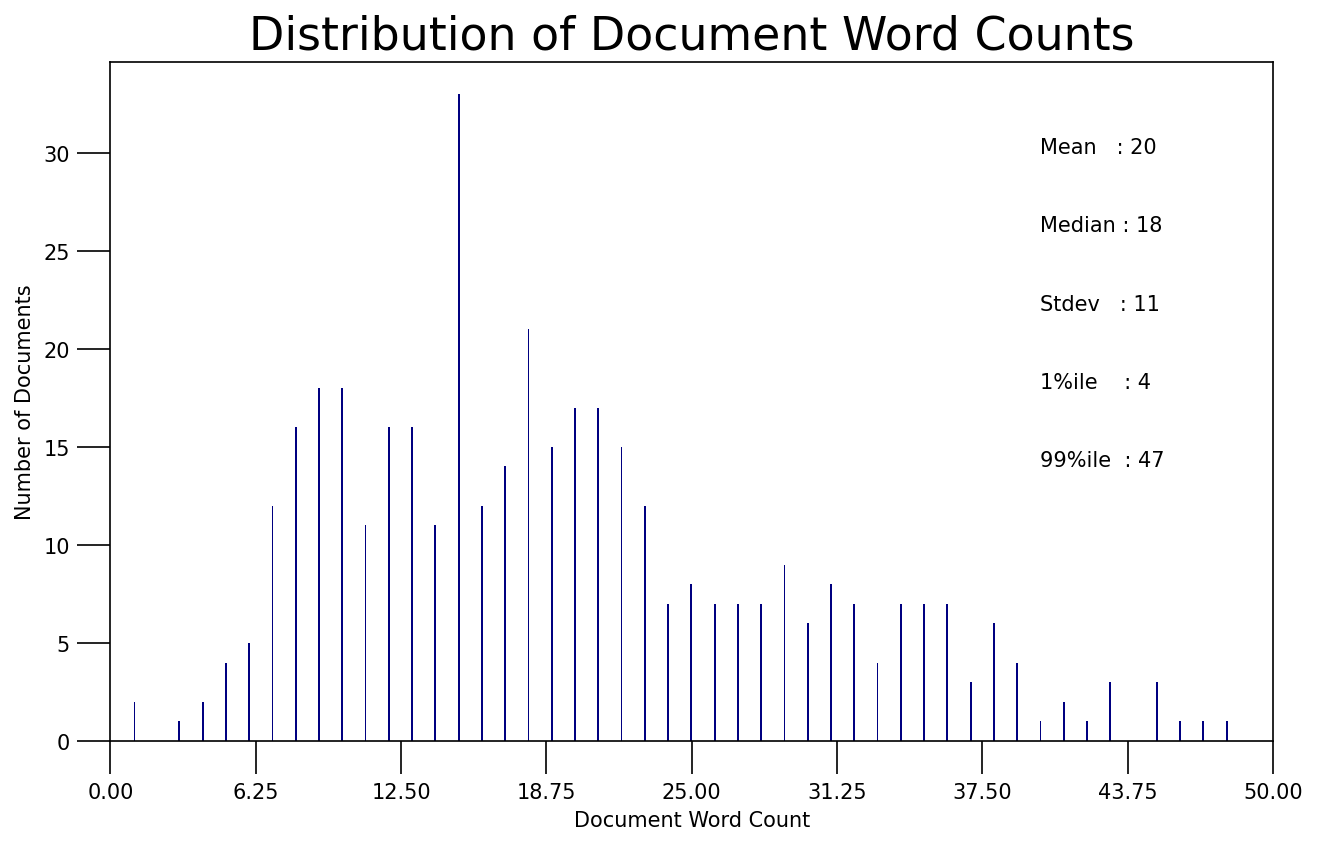

In [52]:
#Distribution of word count
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(10,6), dpi=150)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(40,  30, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(40,  26, "Median : " + str(round(np.median(doc_lens))))
plt.text(40,  22, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(40,  18, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(40,  14, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 50), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,50,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

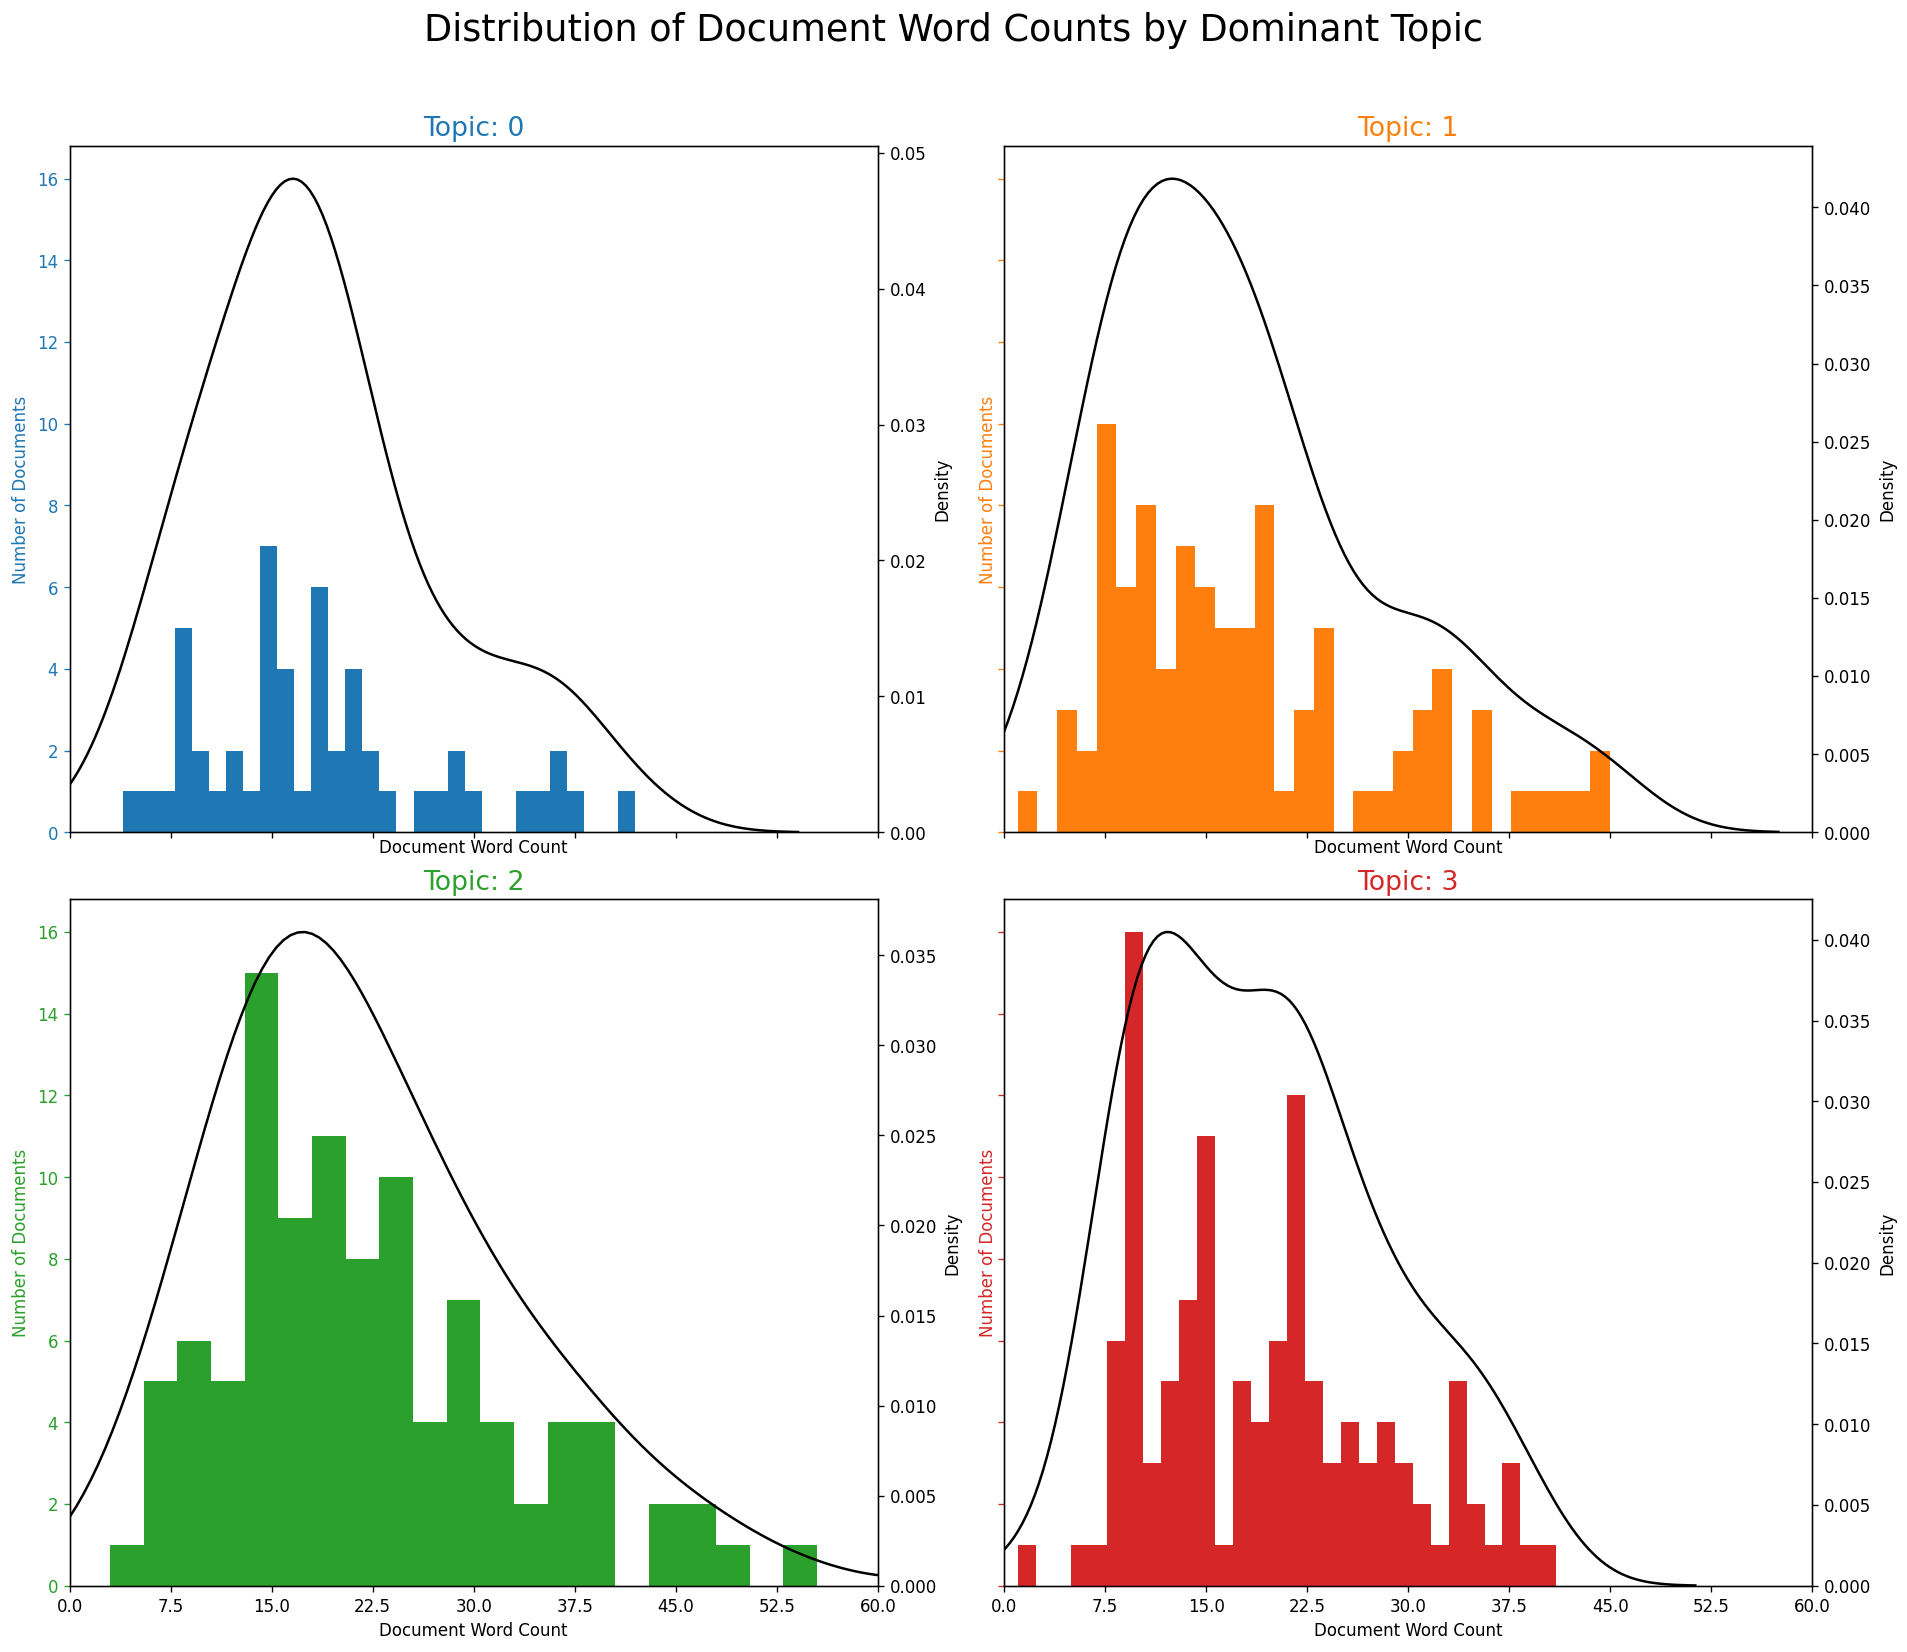

In [67]:
#Playing around with seaborn
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=120, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 30, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 60), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,60,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

__Word Clouds__

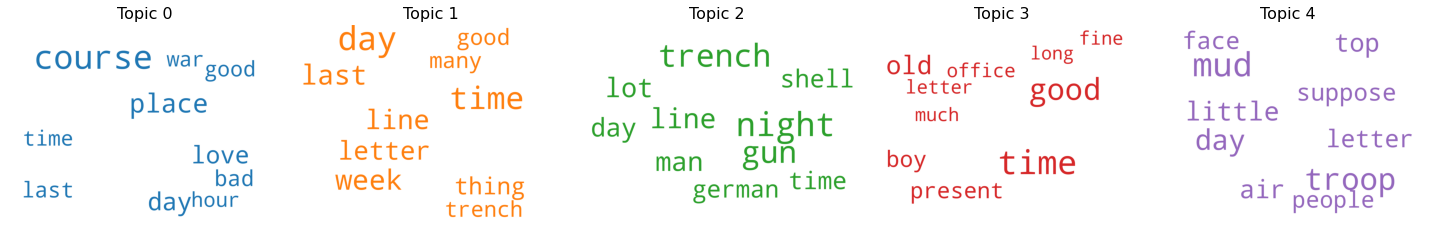

In [60]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(num_topics = 5, formatted=False)

fig, axes = plt.subplots(1, 5, figsize=(20,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


In [63]:
from collections import Counter

topics = lda_model.show_topics(num_topics = 5, formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 1, figsize=(20,15), sharey=True, dpi=200)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 300)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

NameError: name 'data_ready' is not defined

In [66]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics=True)
pyLDAvis.display(lda_display)